In [370]:
import instaloader
import pandas as pd 
import time
import os
from google.cloud import vision

In [106]:
#initializing. Set user name as 'zara' 
L = instaloader.Instaloader()
user_name = 'zara'
profile = instaloader.Profile.from_username(L.context, user_name)#.get_posts()

#Data frame to store the relevant columns 
posts_df = pd.DataFrame(columns=['post_url', 'num_comments', 'num_likes', 'caption', 'image_url', 'is_video'])

#we get the post shortcode using instaloader- use that to create the url 
post_url_structure = 'https://www.instagram.com/p/{}/'

# get the posts from the user_name
posts = profile.get_posts()

# number of posts to extract and initialize the counter
num_posts_to_extract = 800
number = 0 
#to tract the scraping process. The loop will print the number of posts extract at the following intervals
print_list = list(range(0,800,50))

In [107]:
start_time = time.time()
for post in posts:
    
    #print out the number of posts extracted at regular intervals
    if number < num_posts_to_extract:
        if number in print_list:
            print ('{} posts extracted '.format(number))
            
        #increase the counter by 1
        number += 1
        
        #append the required post details to the initialized dataframe 
        posts_df = posts_df.append({'post_url': post_url_structure.format(post.shortcode),
                                    'num_comments': post.comments,
                                    'num_likes': post.likes,
                                    'caption': post.caption,
                                    'image_url': post.url, 
                                    'is_video': post.is_video}, ignore_index=True)
        
        #convert the is_video column to bool - if we get enough posts that are not videos, then break the loop
        posts_df.is_video.astype('bool')
        if posts_df[posts_df.is_video == False].shape[0] == num_posts_to_extract:
            number = num_posts_to_extract
        
        
    else:
        break
    
#total time taken to extract number of posts in num_posts_to_extract variable
total_time_taken = time.time() - start_time
total_time_taken

0 posts extracted 
50 posts extracted 
100 posts extracted 
150 posts extracted 
200 posts extracted 
250 posts extracted 
300 posts extracted 
350 posts extracted 
400 posts extracted 
450 posts extracted 
500 posts extracted 
550 posts extracted 
600 posts extracted 
650 posts extracted 
700 posts extracted 
750 posts extracted 


40.321314334869385

In [108]:
len(posts_df[posts_df.is_video == False])

660

In [109]:
image_df=posts_df[posts_df.is_video == False][:500]
len(image_df)

500

In [110]:
image_df.to_csv (r'C:\Users\Lai Jiang\Desktop\PYUDEMY\TA HW3\IG_image_data.csv', index = False, header=True)

In [208]:
cs_directory = 'C:\\Users\\Lai Jiang\\Desktop\\PYUDEMY\\TA HW3\\'
#os.chdir(cs_directory)
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]= cs_directory + "cs.json"

#utilities for image properties

client = vision.ImageAnnotatorClient()
image = vision.Image()

def extract_labels_from_gvision(image_url):
    """Detects labels in the file located in Google Cloud Storage or on the
    Web."""
    image.source.image_uri = image_url
    response = client.label_detection(image=image)
    label=[]
    for i in response.label_annotations:
        label.append(i.description)
    return label

    
image_df['labels'] = image_df['image_url'].apply(extract_labels_from_gvision)
image_df.head() 

,post_url,num_comments,num_likes,caption,image_url,is_video,labels
0,https://www.instagram.com/p/CGdByXPhb0J/,352,71769,FW20 Campaign. Kids Collection\nCreative Direc...,https://scontent-dfw5-1.cdninstagram.com/v/t51...,False,"[Clothing, Fashion, Outerwear, Fur, Street fas..."
1,https://www.instagram.com/p/CGcs5sHBXp5/,117,37874,FW20 Campaign. Kids Collection\nCreative Direc...,https://scontent-dfw5-1.cdninstagram.com/v/t51...,False,"[Sky, Darkness, Room, Adventure game, Music ve..."
2,https://www.instagram.com/p/CGcEoEkh5hX/,188,55444,FW20 Campaign. Kids Collection\nCreative Direc...,https://scontent-dfw5-1.cdninstagram.com/v/t51...,False,"[Cool, Fashion, Jeans, Sitting, Denim, Shoe, S..."
3,https://www.instagram.com/p/CGacyX7BvYy/,99,34543,FW20 Campaign. Man Collection\nCreative Direct...,https://scontent-dfw5-1.cdninstagram.com/v/t51...,False,"[Hair, Face, Hairstyle, Eyebrow, Forehead, Chi..."
4,https://www.instagram.com/p/CGZ3BIVB_Hb/,180,34166,FW20 Campaign. Man Collection\nCreative Direct...,https://scontent-dfw5-1.cdninstagram.com/v/t51...,False,"[Snapshot, Standing, Hand, Arm, Human, Photogr..."


In [211]:
image_df.to_csv (r'C:\Users\Lai Jiang\Desktop\PYUDEMY\TA HW3\IG_image_data.csv', index = False, header=True)

In [213]:
import statistics

image_df['likes_scaled'] = image_df['num_likes'] / image_df['num_likes'].max()
image_df['comments_scaled'] = image_df['num_comments'] / image_df['num_comments'].max()


like_weight = 0.4
comment_weight = 0.6

image_df['engagement_score'] = image_df['likes_scaled']*like_weight + image_df['comments_scaled']*comment_weight

import numpy as np 
# engagement_high = 1, if the score above the  median value

def engagement_high(engagement_score):
    if engagement_score > image_df['engagement_score'].median():
        return 1
    else:
        return 0

In [217]:
image_df['engagement_high'] = image_df['engagement_score'].apply(engagement_high)

In [219]:
image_df['engagement_high'].value_counts()

1    250
0    250
Name: engagement_high, dtype: int64

In [273]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score 
from sklearn.metrics import confusion_matrix
import nltk
from nltk.corpus import stopwords
from string import punctuation
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="black" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
print("="*100)
from sklearn.metrics import confusion_matrix
#print("Train confusion matrix")

In [221]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [490]:
df=image_df.reset_index()

In [491]:
#label only
def labeljoin(labels):
    return ' '.join(labels)

df['labels'] = df['labels'].apply(labeljoin)
#Vectorizer
corpus2=df['labels'].astype(str)
vectorizer = TfidfVectorizer(max_features=500)
X = vectorizer.fit_transform(corpus2)
y = df['engagement_high']

In [492]:
#labels only test & train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

Accuracy Score: 0.61
ROC_AUC Score: 0.6368760064412238
F1 Score: 0.5894736842105263
Confusion Matrix:
Confusion matrix, without normalization


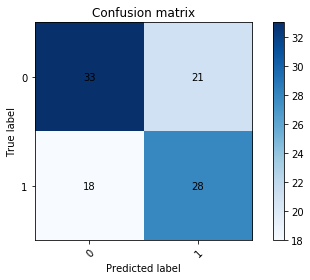

In [493]:
#Log. Reg image labels only
model = LogisticRegression()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
y_pred_score = model.predict_proba(X_test)[:,1]
cm = confusion_matrix(y_test, y_pred)

print('Accuracy Score:',accuracy_score(y_test,y_pred))
print('ROC_AUC Score:',roc_auc_score(y_test,y_pred_score))
print('F1 Score:',f1_score(y_test,y_pred))
print('Confusion Matrix:')
#pd.DataFrame(cm, columns=['actual', 'predicted'])

plot_confusion_matrix(y_true = y_test, 
                      y_pred = y_pred, classes = np.unique(y_test),
                     title = 'Confusion matrix')

In [494]:
#Caption only
#data cleaning
def remove_atsign(caption):
    result = re.sub(r"@\S+", "", caption)
    result = result.replace('\n', '').replace('/','').replace('—','').replace('|','')
    return result

def remove_hashtag(caption):
    result = re.sub(r"#\S+", "", caption)
    return result

def remove_punctuation(caption):
    for term in punctuation:
        caption = caption.replace(term,'')
    return caption

In [495]:
df['caption'] = df ['caption'].apply(remove_atsign)
df['caption'] = df ['caption'].apply(remove_hashtag)
df['caption'] = df ['caption'].apply(remove_punctuation)

In [496]:
#tfidf vectorizer
corpus1 = df['caption'].astype(str) 
vectorizer = TfidfVectorizer(stop_words='english',max_features=2000)
X = vectorizer.fit_transform(corpus1)
y = df['engagement_high']

In [497]:
#caption only test & train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

Accuracy Score: 0.69
ROC_AUC Score: 0.7566425120772947
F1 Score: 0.6666666666666667
Confusion Matrix:
Confusion matrix, without normalization


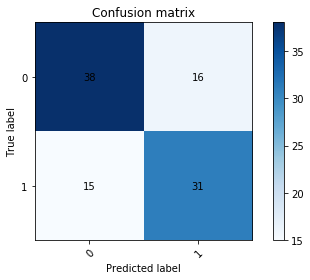

In [498]:
#Log. Reg captions only
model = LogisticRegression()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
y_pred_score = model.predict_proba(X_test)[:,1]
cm = confusion_matrix(y_test, y_pred)

print('Accuracy Score:',accuracy_score(y_test,y_pred))
print('ROC_AUC Score:',roc_auc_score(y_test,y_pred_score))
print('F1 Score:',f1_score(y_test,y_pred))
print('Confusion Matrix:')

plot_confusion_matrix(y_true = y_test, 
                      y_pred = y_pred, classes = np.unique(y_test),
                     title = 'Confusion matrix')

In [499]:
#Concat captions and image labels
df['cap_label'] = df['caption'] + df['labels']

In [500]:
#Vectorize
corpus3 = df['cap_label'].tolist()
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(corpus3)
y = df['engagement_high']

In [501]:
#caption only test & train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Accuracy Score: 0.69
ROC_AUC Score: 0.7804
F1 Score: 0.686868686868687
Confusion Matrix:
Confusion matrix, without normalization


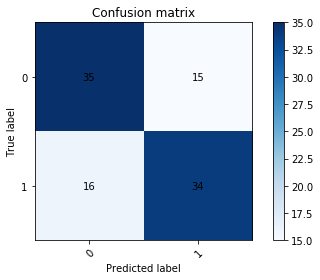

In [502]:
#Log. Reg. captions & image labels
model = LogisticRegression()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
y_pred_score = model.predict_proba(X_test)[:,1]
cm = confusion_matrix(y_test, y_pred)

print('Accuracy Score:',accuracy_score(y_test,y_pred))
print('ROC_AUC Score:',roc_auc_score(y_test,y_pred_score))
print('F1 Score:',f1_score(y_test,y_pred))
print('Confusion Matrix:')
plot_confusion_matrix(y_true = y_test, 
                      y_pred = y_pred, classes = np.unique(y_test),
                     title = 'Confusion matrix')
#pd.DataFrame(cm, columns=['actual', 'predicted'])

Topic Modelling using LDA
Topic modeling (LDA) on the image labels.
Appropriate number of topics were selected using trial and error. Started with 5, but adjusted the number up or down depending on the word distributions I got.

Two outputs were generated:

(i) A file showing which words load on which topics

(ii) a file showing topic weights for each image.

In [503]:
from sklearn.feature_extraction.text import CountVectorizer
import re
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
from sklearn.decomposition import LatentDirichletAllocation as LDA

In [504]:
df['label_processed'] = df['labels'].map(lambda x: x.lower())
df['label_processed'].head()

0    clothing fashion outerwear fur street fashion ...
1    sky darkness room adventure game music venue n...
2          cool fashion jeans sitting denim shoe style
3    hair face hairstyle eyebrow forehead chin head...
4    snapshot standing hand arm human photography s...
Name: label_processed, dtype: object

In [505]:
#bag of words
count_vectorizer = CountVectorizer(stop_words='english')
count_data = count_vectorizer.fit_transform(df['label_processed'])

In [542]:
# print topic and words
def print_topics(model, count_vectorizer, num_words):
    words = count_vectorizer.get_feature_names()
    for topic_num, topic_words in enumerate(model.components_):
        print("\nTopic #%d:" % topic_num)
        print(" ".join([words[i]
                        for i in topic_words.argsort()[:-num_words-1:-1]]))
        
#parameters
number_topics = 2
number_words = 10

#LDA model
lda = LDA(n_components=number_topics, n_jobs=-1,random_state=88)
lda.fit(count_data)

# Print topics
print("Topics found:")
print_topics(lda, count_vectorizer, number_words)

Topics found:

Topic #0:
photography white black monochrome sitting child leg photograph human shoe

Topic #1:
fashion clothing outerwear shoulder hair beauty model dress white shoot


Topic 0 : Photography <br>
Topic 1 : Fashion

In [556]:

#get words
words=count_vectorizer.get_feature_names()
words_df=pd.DataFrame(words)
#word distribution for each topic
word_dist=pd.DataFrame(lda.components_)
word_dist.T.rename(columns={0:'T0',1:'T1'}).head()
#Look at word vs distribution
words_df.merge(word_dist.T,left_index=True, right_index=True)\
.rename(columns={'0_x':'words','0_y':'Photography',1:'Fashion'}).head()

,words,Photography,Fashion
0,abdomen,1.199272,3.800728
1,accessory,10.229085,8.770915
2,acting,0.503736,1.496264
3,active,1.987686,1.012314
4,adaptation,2.466055,0.533945


the word loads differently towars different topics most of the time so number of topics being 2 seems correct. <br>
Topic 0 : Photography <br>
Topic 1 : Fashion

In [562]:
#getting topic weights
weights=lda.transform(count_data)
topic_weights=pd.DataFrame(weights)
topic_weights
#columns = Topic ; rows = words index

,0,1
0,0.118786,0.881214
1,0.963807,0.036193
2,0.434563,0.565437
3,0.047690,0.952310
4,0.931461,0.068539
5,0.057783,0.942217
6,0.963552,0.036448
7,0.467511,0.532489
8,0.508937,0.491063
9,0.091592,0.908408


Now take the quartiles with highest and lowest engagement scores. What are the differences in the average topic weights of pictures across the two quartiles (e.g., greater proportion of some topics in highest engagement quartile)? Show the main results in a table.

In [570]:
df=df.merge(topic_weights, left_index=True, right_index=True)

In [564]:
df=df.sort_values(by=['engagement_score'])
q1=np.percentile(df['engagement_score'], 25)
q3=np.percentile(df['engagement_score'], 75)
#average topic scores for low and high engagement quartile
pd.DataFrame({'Topic':['Photography','Fashion'],
              'Low_engagement':df[df['engagement_score']<=q1]\
              [df.columns[-number_topics:]].mean(),\
              'High_engagement':df[df['engagement_score']>=q3][df.columns[-number_topics:]].mean()})
#rows = topic name

,Topic,Low_engagement,High_engagement
0,Photography,0.431982,0.276659
1,Fashion,0.568018,0.723341
